In [1]:
import tensorflow as tf
import tensorflow.keras.utils as image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from IPython.display import clear_output

2023-09-14 20:23:36.161193: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-14 20:23:36.240474: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-14 20:23:36.241749: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 20:23:38.098245: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Download an image and read it into a NumPy array,
def download(url):
    name = url.split("/")[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = image.load_img(image_path)
    return image.img_to_array(img)

In [3]:
# Scale pixels to between (-1.0 and 1.0)
def preprocess(img):
    return (img / 127.5) - 1

In [4]:
# Undo the preprocessing above
def deprocess(img):
    img = img.copy()
    img /= 2.
    img += 0.5
    img *= 255.
    return np.clip(img, 0, 255).astype('uint8')

In [5]:
# Display an image
def show(img):
    plt.figure(figsize=(12,12))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)

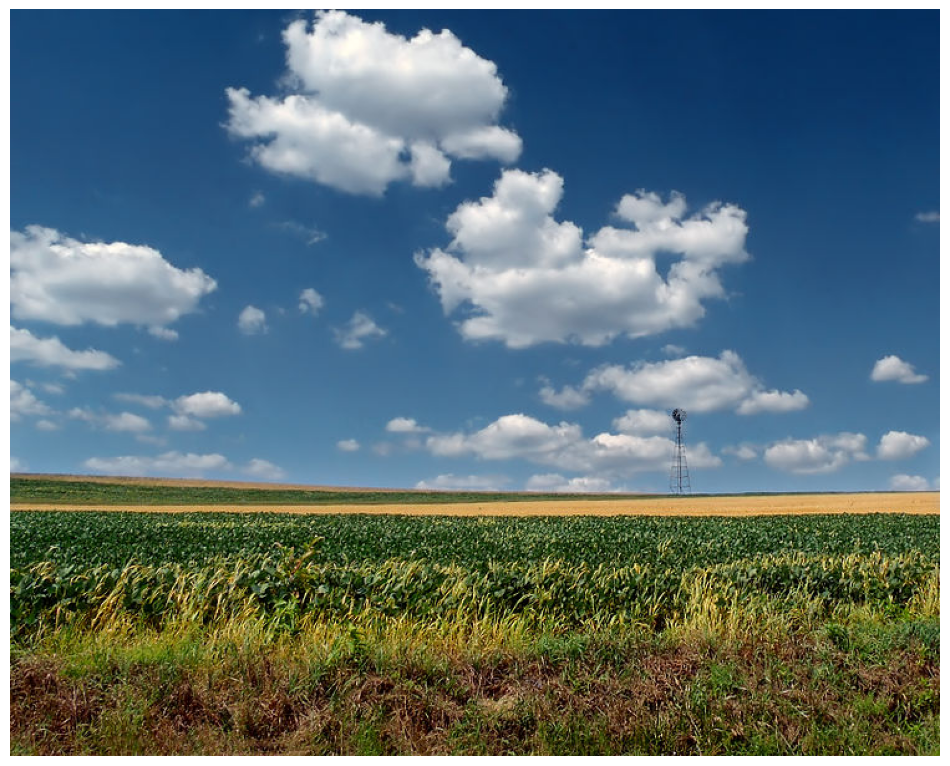

In [6]:
# https://commons.wikimedia.org/wiki/File:Flickr_-_Nicholas_T_-_Big_Sky_(1).jpg
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/Flickr_-_Nicholas_T_-_Big_Sky_%281%29.jpg/747px-Flickr_-_Nicholas_T_-_Big_Sky_%281%29.jpg'
img = preprocess(download(url))
show(deprocess(img))

In [7]:
inception_v3 = InceptionV3(weights='imagenet', include_top=False)

# We'll maximize the activations of these layers
names = ['mixed2', 'mixed3', 'mixed4', 'mixed5']
layers = [inception_v3.get_layer(name).output for name in names]

# Create our feature extraction model
feat_extraction_model = tf.keras.Model(inputs=inception_v3.input, outputs=layers)

def forward(img):
    # Create a batch
    img_batch = tf.expand_dims(img, axis=0)
    # Forward the image through Inception, extract activations
    # for the layers we selected above
    return feat_extraction_model(img_batch)

2023-09-14 20:23:41.951512: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
def calc_loss(layer_activations):
    total_loss = 0
    for act in layer_activations:
        # In gradient ascent, we'll want to maximize this value
        # so our image increasingly "excites" the layer
        loss = tf.math.reduce_mean(act)
        # Normalize by the number of units in the layer
        loss /= np.prod(act.shape)
        total_loss += loss
    return total_loss

Step 350, loss 0.000003


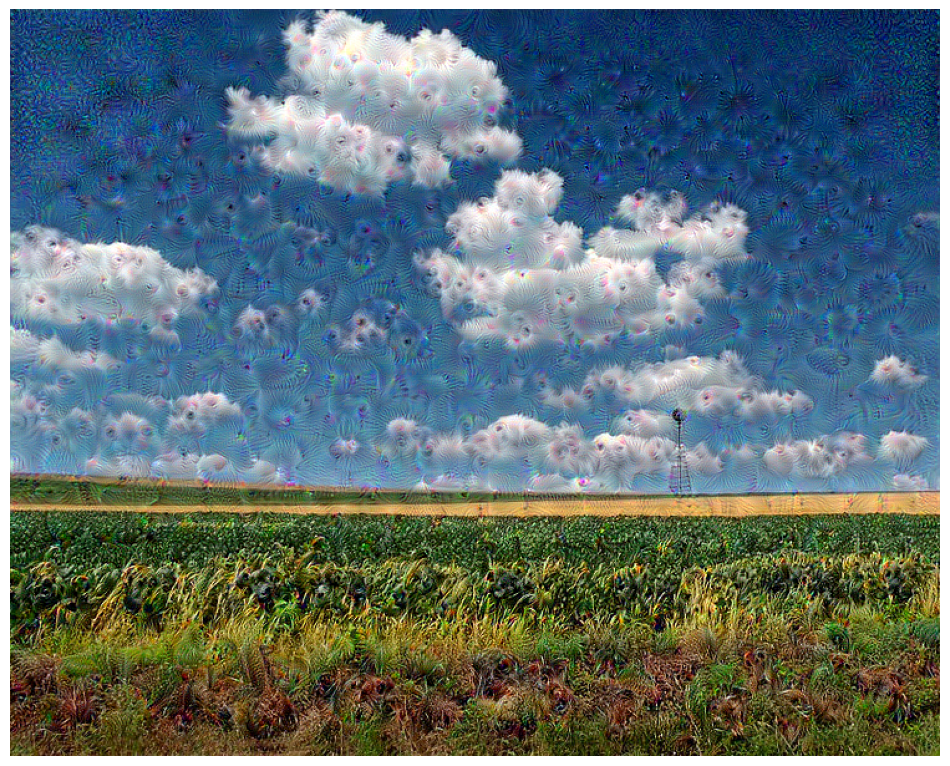

In [9]:
img = tf.Variable(img)
steps = 400

for step in range(steps):
    with tf.GradientTape() as tape:
        activations = forward(img)
        loss = calc_loss(activations)
    gradients = tape.gradient(loss, img)
    # Normalize the gradients
    gradients /= gradients.numpy().std() + 1e-8
    
    # Update our image by directly adding the gradients
    img.assign_add(gradients)
    
    if step % 50 == 0:
        clear_output()
        print ("Step %d, loss %f" % (step, loss))
        show(deprocess(img.numpy()))
        plt.show()

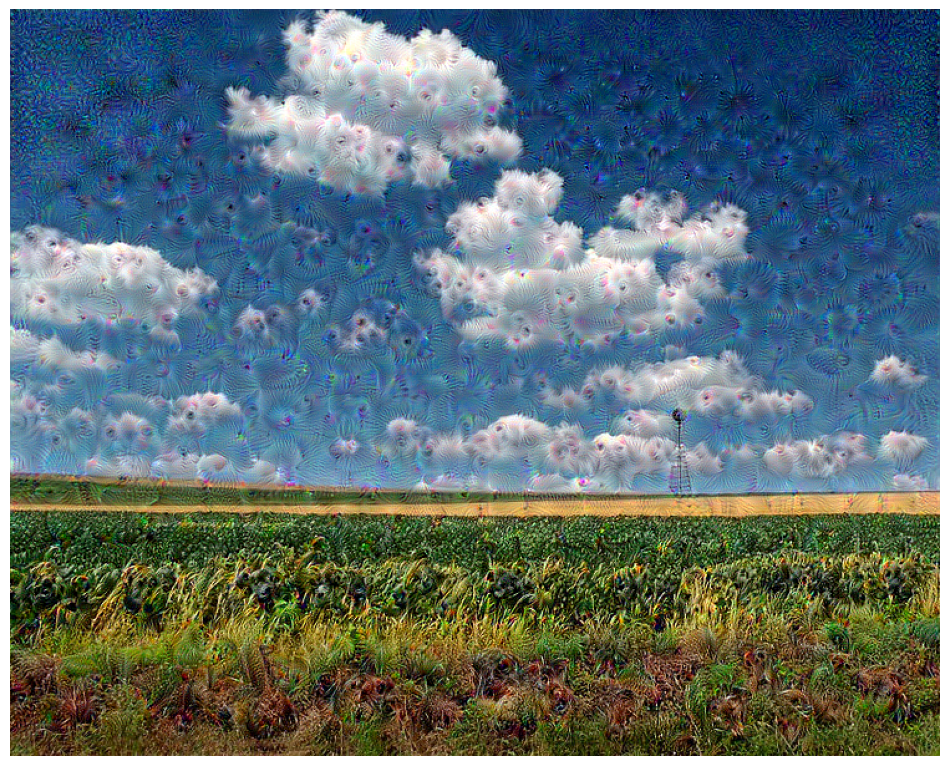

In [10]:
# Let's see the result
clear_output()
show(deprocess(img.numpy()))